---
*   **author:** Marián Pukančík
*   **učo**: 506485
*   **title:** Brain MRI classification and segmentation
*   **subject:** PA026

---

This notebook contains AN implementation of ensemble model for brain MRI classification. Model will decide whether the input image (with 3 channels) does/doesn't contain brain tumor. 

In terms of data, two datasets are utilized. One, also reffered to as 'main' dataset, available here: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation, containing aroud 3900 multimodal images. For each image we have the original version, post-contrast T1 weighted and T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) version. The second dataset (additional classification one) is available here:https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download. From this, only images containing Glioma tumors and (some to balance the entire dataset) images without tumors were used, providing around 2400 additional images. However, these images have only a single channel, so this channel is copied in order to produce consistent shape accross all data.

The ensemble consists of 3 models, each using pretrained feature extractor, namely Resnet50, InceptionV3 and InceptionResNetV2. These feature extractors are then finetuned for our task. The final image label is decided by majority voting of these three models.

---

**IMPORTANT:** This notebook was created in Google Colaboratory enviroment. It expects that data is already present on Google drive. There are .csv files present in .zip file containing paths and labels to individual images. They also determine the split for train and test data. If you don't have these files, you will have to generate them by uncommenting proper code cells below. You might also have to adjust file paths if necessary. For specific instructions, please refer to the project .pdf report file.

---

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import tensorflow as tf
from tensorflow.python.keras import Sequential
from keras import layers, optimizers
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# Voor GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[GOOGLE COLABORATORY] For running the notebook via Google Colaboratory, you might need to slightly change the project path. It expects the project directory to be upluaded on your Google Drive.

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the path to project directory
PROJECT_PATH = '/content/drive/My Drive/PA026/'

# Add project path into the system path
sys.path.insert(0,PROJECT_PATH)

Mounted at /content/drive


[LOCAL MACHINE] If you want to run this on your local machine, run this cell instead of the one above. However, keep in mind that this project was developed in Google Colaboratory enviroment, so i cannot guarantee 100 percent functionalty elsewhere. With that beeing said, it was tested on different machine and run well, so it should work. 

In [ ]:
# for running on your local machine
#PROJECT_PATH = './'

In [ ]:
from scripts import dataFunctions

# Data preparation

If you already have the 'mainClassSegData.csv' file then run the following cell as it is. If not, uncomment the first line of code in order to generate .csv file containing filepaths and labels for the main dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3929 non-null   int64 
 1   image       3929 non-null   object
 2   mask        3929 non-null   object
 3   label       3929 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 122.9+ KB
None


<Axes: xlabel='label', ylabel='count'>

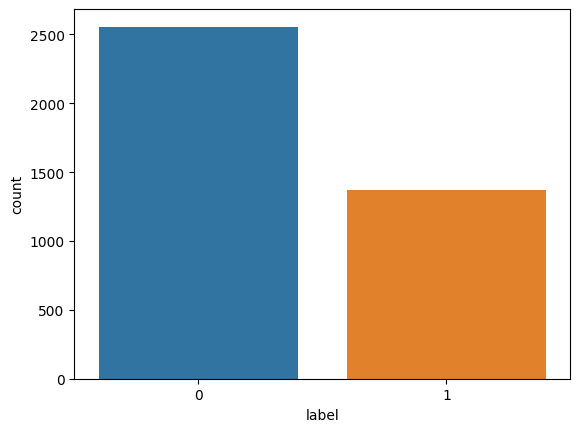

In [ ]:
#dataFunctions.getMainDatasetPaths(PROJECT_PATH)
data = pd.read_csv(PROJECT_PATH+'data/mainClassSegData.csv')
print(data.info())
sns.countplot(data=data, x='label')

If you already have the 'testData.csv', 'mainWithoutTestData.csv' and 'allClassData.csv' files then there is no need to run the following cell. If not, run it in order to generate these .csv files.

*   testData.csv - test data file paths for images, corresponding segmentation ground truth label maps, and class labels from the main dataset
*   mainWithoutTestData.csv - data file paths (except the test ones) for images, corresponding segmentation ground truth label maps, and class labels from the main dataset
*   allClassData.csv - train data file paths for images, corresponding segmentation ground truth label maps, and class labels from the main dataset. And data file paths for images with corresponding labels from additional classification dataset



In [ ]:
# Create test dataset for all models (classification and segmentation)
'''classificationData, testData = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
testData = testData.drop(columns=['Unnamed: 0'])
testData.to_csv(PROJECT_PATH+'data/testData.csv') 

# save the file paths for segmentation train dataset
classificationData.to_csv(PROJECT_PATH+'data/mainWithoutTestData.csv')

# add additional classification data 
classificationData = dataFunctions.addAditionalDataset(classificationData, PROJECT_PATH)
classificationData = classificationData.drop(columns=['Unnamed: 0'])
classificationData.to_csv(PROJECT_PATH+'data/allClassData.csv')'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   786 non-null    object
 1   label   786 non-null    object
dtypes: object(2)
memory usage: 12.4+ KB
None


<Axes: xlabel='label', ylabel='count'>

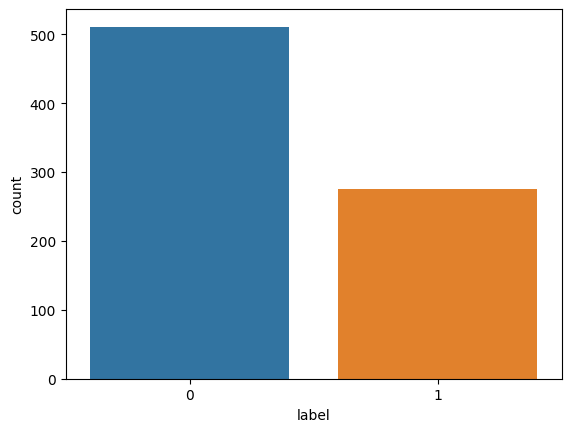

In [ ]:
# read the test data
testData = pd.read_csv(PROJECT_PATH+'data/testData.csv')
# for image classifcation, we don't need mask file paths 
testData = testData.drop(columns=['Unnamed: 0', 'mask'])
# Convert the data in label column to string format, to use categorical mode in flow_from_dataframe
testData['label'] = testData['label'].apply(lambda x: str(x))
print(testData.info())
sns.countplot(data=testData, x='label')

In [ ]:
# read the train data for image classification
classificationData = pd.read_csv(PROJECT_PATH+'data/allClassData.csv')
# for image classifcation, we don't need mask file paths 
classificationData = classificationData.drop(columns=['Unnamed: 0','mask'])
# Convert the data in label column to string format, to use categorical mode in flow_from_dataframe
classificationData['label'] = classificationData['label'].apply(lambda x: str(x))
print(classificationData.info())
sns.countplot(data=classificationData, x='label')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562 entries, 0 to 5561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5562 non-null   object
 1   label   5562 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB
None


<Axes: xlabel='label', ylabel='count'>

## Preprocessing, augmentations and data generators

In [ ]:
BATCH_SIZE = 30

# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

In [ ]:
# define preprocessing steps(only normalization) and augmentations for train and validation data generators
datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1,
        rotation_range = 45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

trainGenerator = datagen.flow_from_dataframe(
        classificationData,
        directory='./',
        x_col='image',
        y_col='label',
        subset='training',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT)
    )
valGenerator = datagen.flow_from_dataframe(
        classificationData,
        directory='./',
        x_col='image',
        y_col='label',
        subset='validation',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT)
    )

# define preprocessing steps(only normalization) for test data generator
testDatagen = ImageDataGenerator(rescale=1./255.)

testGenerator = testDatagen.flow_from_dataframe(
        testData,
        directory='./',
        x_col='image',
        y_col='label',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False,
        target_size=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT)
    )

Found 5006 validated image filenames belonging to 2 classes.
Found 556 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


# Define, train and evaluate classification models, use transfer learning

In [ ]:
# initialize learning rate, number of epochs to train for
INIT_LR = 0.001
NUM_EPOCHS = 40

## ResNet50

In [ ]:
# get pretrained feature extractor
featureExtractor = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))

# add custom layers for our problem (binary classification)
model = tf.keras.Sequential(
    [   
        featureExtractor,
        layers.AveragePooling2D(pool_size=(4,4)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
        loss = 'categorical_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), 
        metrics= ["accuracy"]
    )
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 2, 2, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [ ]:
# define callbacks
earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=15
    )
checkpointer = ModelCheckpoint(
        filepath=PROJECT_PATH+"savedModels/classification/ResNet50Model_weights.hdf5", 
        verbose=1, 
        save_best_only=True
    )

# retrain the model
h = model.fit(
        trainGenerator, 
        epochs = NUM_EPOCHS, 
        validation_data= valGenerator, 
        callbacks=[checkpointer, earlystopping]
    )

Epoch 1/40
167/167 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.7685
Epoch 1: val_loss improved from inf to 61.93935, saving model to /content/drive/My Drive/PA026/savedModels/classification/ResNet50Model_weights.hdf5
167/167 [==============================] - 967s 5s/step - loss: 0.5895 - accuracy: 0.7685 - val_loss: 61.9394 - val_accuracy: 0.3327
Epoch 2/40
167/167 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8384
Epoch 2: val_loss improved from 61.93935 to 0.64464, saving model to /content/drive/My Drive/PA026/savedModels/classification/ResNet50Model_weights.hdf5
167/167 [==============================] - 124s 739ms/step - loss: 0.4037 - accuracy: 0.8384 - val_loss: 0.6446 - val_accuracy: 0.6673
Epoch 3/40
167/167 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8755
Epoch 3: val_loss improved from 0.64464 to 0.64317, saving model to /content/drive/My Drive/PA026/savedModels/classification/ResNet50Model_wei

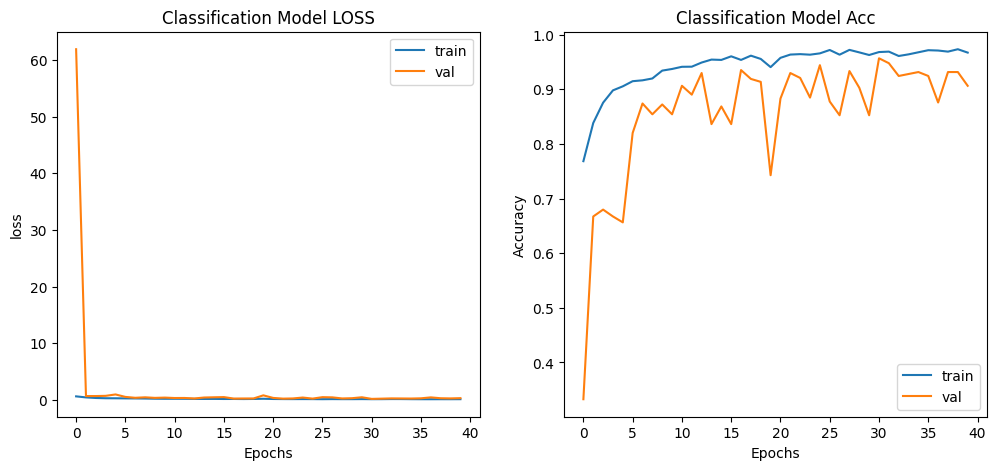

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

### Evaluate

In [ ]:
prediction = model.predict(testGenerator)
pred = np.argmax(prediction, axis=1)
original = np.asarray(testData['label']).astype('int')

accuracy = accuracy_score(original, pred)
print(accuracy)

cf = confusion_matrix(original, pred)
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cf, annot=True, fmt="d")

27/27 [==============================] - 5s 156ms/step
0.9185750636132316
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       511
           1       0.91      0.85      0.88       275

    accuracy                           0.92       786
   macro avg       0.92      0.90      0.91       786
weighted avg       0.92      0.92      0.92       786



## InceptionV3

In [ ]:
# get pretrained feature extractor
featureExtractor = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))

# add custom layers for our problem (binary classification)
model = tf.keras.Sequential(
    [   
        featureExtractor,
        layers.AveragePooling2D(pool_size=(4,4)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(
        loss = 'categorical_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), 
        metrics= ["accuracy"]
    )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 average_pooling2d_10 (Avera  (None, 1, 1, 2048)       0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                      

In [ ]:
# define callbacks
earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=15
    )
checkpointer = ModelCheckpoint(
        filepath=PROJECT_PATH+"savedModels/classification/InceptionV3Model_weights.hdf5", 
        verbose=1, 
        save_best_only=True
    )

# retrain the model
h = model.fit(
        trainGenerator, 
        epochs = NUM_EPOCHS, 
        validation_data= valGenerator, 
        callbacks=[checkpointer, earlystopping]
    )

Epoch 1/40
167/167 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.8182
Epoch 1: val_loss improved from inf to 3.82177, saving model to /content/drive/My Drive/PA026/savedModels/classification/InceptionV3Model_weights.hdf5
167/167 [==============================] - 177s 783ms/step - loss: 0.3944 - accuracy: 0.8182 - val_loss: 3.8218 - val_accuracy: 0.4424
Epoch 2/40
167/167 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.8957
Epoch 2: val_loss did not improve from 3.82177
167/167 [==============================] - 113s 674ms/step - loss: 0.2565 - accuracy: 0.8957 - val_loss: 153.7738 - val_accuracy: 0.3885
Epoch 3/40
167/167 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.9055
Epoch 3: val_loss improved from 3.82177 to 1.10151, saving model to /content/drive/My Drive/PA026/savedModels/classification/InceptionV3Model_weights.hdf5
167/167 [==============================] - 114s 679ms/step - loss: 0.2429 - accuracy: 0

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

### Evaluate

27/27 [==============================] - 7s 150ms/step
0.9580152671755725
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       511
           1       0.96      0.92      0.94       275

    accuracy                           0.96       786
   macro avg       0.96      0.95      0.95       786
weighted avg       0.96      0.96      0.96       786



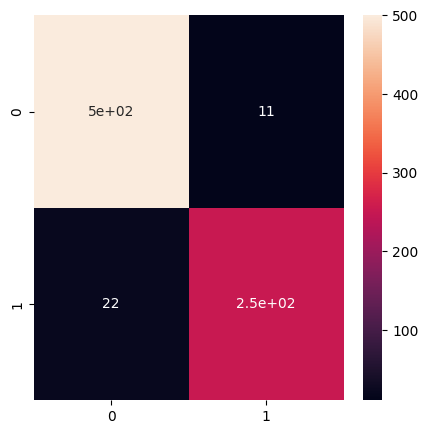

In [ ]:
prediction = model.predict(testGenerator)
pred = np.argmax(prediction, axis=1)
original = np.asarray(testData['label']).astype('int')

accuracy = accuracy_score(original, pred)
print(accuracy)

cf = confusion_matrix(original, pred)
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cf, annot=True, fmt="d")

## InceptionResNetV2

In [ ]:
# get feature extractor
featureExtractor = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))

# add custom layers for our problem (binary classification)
model = tf.keras.Sequential(
    [   
        featureExtractor,
        layers.AveragePooling2D(pool_size=(4,4)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ]
)

model.compile(loss = 'categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), 
              metrics= ["accuracy"]
             )
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 average_pooling2d_12 (Avera  (None, 1, 1, 1536)       0         
 gePooling2D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [ ]:
# define augmentations
earlystopping = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=15
    )
checkpointer = ModelCheckpoint(
        filepath=PROJECT_PATH+"savedModels/classification/InceptionResNetV2Model_weights.hdf5", 
        verbose=1, 
        save_best_only=True
    )

# retrain the model
h = model.fit(
        trainGenerator, 
        epochs = NUM_EPOCHS, 
        validation_data= valGenerator, 
        callbacks=[checkpointer, earlystopping]
    )

Epoch 1/40
167/167 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8398
Epoch 1: val_loss improved from inf to 276.53537, saving model to /content/drive/My Drive/PA026/savedModels/classification/InceptionResNetV2Model_weights.hdf5
167/167 [==============================] - 254s 905ms/step - loss: 0.3691 - accuracy: 0.8398 - val_loss: 276.5354 - val_accuracy: 0.3327
Epoch 2/40
167/167 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9123
Epoch 2: val_loss improved from 276.53537 to 0.82688, saving model to /content/drive/My Drive/PA026/savedModels/classification/InceptionResNetV2Model_weights.hdf5
167/167 [==============================] - 167s 997ms/step - loss: 0.2235 - accuracy: 0.9123 - val_loss: 0.8269 - val_accuracy: 0.8076
Epoch 3/40
167/167 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9347
Epoch 3: val_loss improved from 0.82688 to 0.29675, saving model to /content/drive/My Drive/PA026/savedModels/classifi

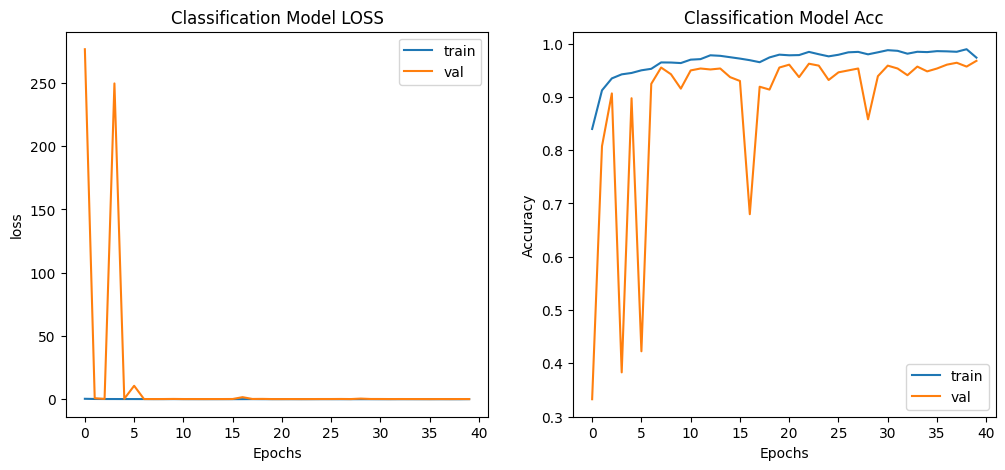

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

### Evaluate

27/27 [==============================] - 6s 207ms/step
0.9592875318066157
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       511
           1       0.97      0.91      0.94       275

    accuracy                           0.96       786
   macro avg       0.96      0.95      0.95       786
weighted avg       0.96      0.96      0.96       786



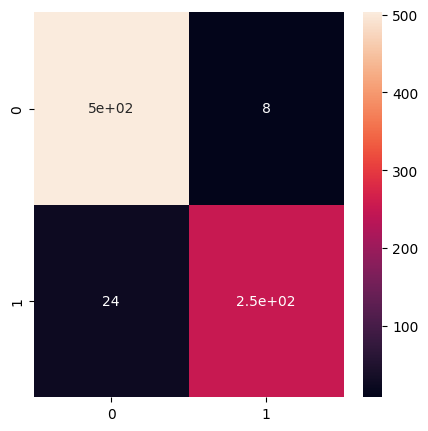

In [ ]:
prediction = model.predict(testGenerator)
pred = np.argmax(prediction, axis=1)
original = np.asarray(testData['label']).astype('int')

accuracy = accuracy_score(original, pred)
print(accuracy)

cf = confusion_matrix(original, pred)
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cf, annot=True, fmt="d")

# Ensemble 

27/27 [==============================] - 9s 230ms/step


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       511
           1       0.98      0.91      0.94       275

    accuracy                           0.96       786
   macro avg       0.96      0.95      0.96       786
weighted avg       0.96      0.96      0.96       786

96.0559796437659


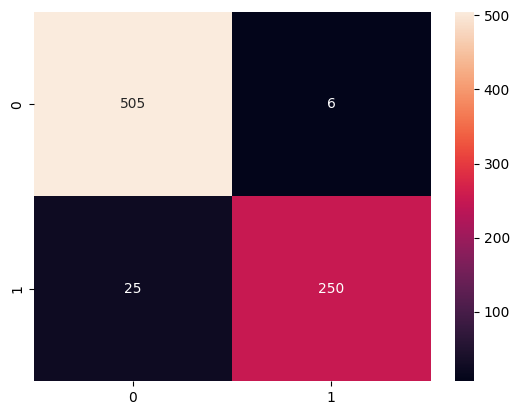

In [ ]:
# get all 3 feature extractors
featureExResNet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))
featureExInception = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))
featureExIncResNet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,3)))

extractors = [featureExResNet, featureExInception, featureExIncResNet]

trainedModels = []
names = ['ResNet50Model_weights', 'InceptionV3Model_weights', 'InceptionResNetV2Model_weights']

# for each extractor
for i, ext in enumerate(extractors):

    # add custom layers for our problem (binary classification)
    model = tf.keras.Sequential(
        [   
            ext,
            layers.AveragePooling2D(pool_size=(4,4)),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(2, activation='softmax')
        ]
    )

    model.compile(loss = 'categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                metrics= ["accuracy"]
                )

    # and load weights that we obtained by retrainig earlier 
    model.load_weights(PROJECT_PATH+'savedModels/classification/'+names[i]+'.hdf5')
    trainedModels.append(model)

# use all 3 models to predict labels for test data
preds = [m.predict(testGenerator) for m in trainedModels]
preds= np.array(preds)
# model weights -  basically the same, we are doing majority voting
weights = [0.3, 0.35, 0.35] 

#use tensordot to get the final labels
weighted_pred = np.tensordot(preds, weights, axes=((0),(0)))

# evaluate the ensemble
weighted_ensemble_pred= np.argmax(weighted_pred, axis=1)
origLabels = np.asarray(testData['label']).astype('int')
weighted_acc = accuracy_score(origLabels, weighted_ensemble_pred)

print('\n')
print(classification_report(origLabels, weighted_ensemble_pred))

cf = confusion_matrix(origLabels, weighted_ensemble_pred)
sns.heatmap(cf, annot=True, fmt="d");